In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

In [3]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, bathymetry: np.ndarray, h_initial: np.ndarray, options: Options = None, n_threads: int = 1):
      # * -> każe że kazdy arggument funkcji musi byc wywołany z nazwy
      # h_initial -> wysokość słupa początkowa
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape #h_initial.shape=2, krotka shape
        stepper = Stepper(options=options, grid=grid, n_threads=n_threads)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),  #powielenie listy razy liczbe, len(grid) = 2
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),   #**kwargs rozpakowuje słownik, czyli tutaj bedzie uruchamiane jako ScalarField(h_nitial, boundry_conditions, halo)
            "uh": ScalarField(np.zeros(grid), **kwargs),  #pole skalarne dla wysokosci (?)
            "vh": ScalarField(np.zeros(grid), **kwargs),  #pole skalarne dla pędu (?)
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }  #tworzy trz solvery h, uh i vh chyba
        self.bathymetry = bathymetry  #to dodane na zajęciach

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()  #nie bedzie pokazywac halo  ten nawias kwadratowy wybierze którys element o numerze klucza z tego solvera

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)  #-self.bathymetry dodane na zzajeciach

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self['h'] > eps  #eps wyznacza plaże
                for axis, key in enumerate(("uh", "vh")):  # axis X lub Y, key "uh" lub "vh"
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis]) #całkowanie prawej strony
                    self.solvers[key].advance(n_steps=1) #cłakowanie adwekcji
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis]) #całkowanie znowu pół prawej strony
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

In [4]:
def bathymetry_f(N, deep, shallow, s_start, s_width, a, b, c, x):
    shape=np.full_like(x, deep)
    k=(x-s_start)/s_width
    dH=(deep-shallow)
    if N==1:
        xa=np.clip(k, 0.0, 1.0)
        shape=deep-dH*xa
    elif N==2:
        k=(x-s_start)/s_width
        xa=np.maximum(k, 0.0)
        shape=shallow+dH*np.exp(-a*xa)
    elif N==3:
        xa=a*k
        shape=shallow+dH*(b*(c-np.tanh(xa)))

    return shape

In [5]:
def tsunami_f(amp, sigma, x0, x):
    tsunami=amp*np.exp((-((x-x0)**2))/(2*sigma**2))
    return tsunami

In [6]:
def plot(frame, *, zlim=(-5, 7)):
    psi = output['h'][frame]-bathymetry 
    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 8))
    ax.plot_wireframe(x, y, psi, color='blue', linewidth=1, rstride=5, cstride=1)  
    ax.set(zlim=zlim, proj_type='ortho', title=f"t / Δt = {frame}")
    ax.set_xlabel("x - Length [m]")
    ax.set_ylabel("y - Width [m]")
    ax.set_zlabel("z - Height [m]")
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)
    pyplot.colorbar(
        ax.contourf(x, y, bathymetry, zdir='z', offset=zlim[0]),
        pad=.1, aspect=20, fraction=.02, label='bathymetry', location='left'
    ).ax.invert_yaxis()
    return fig


In [7]:
def slice_2D_f(N):
    middle_y=ny//2
    bathymetry_profile = -bathymetry[:, middle_y]
    x_ax=x[:,middle_y]
    
    h_states=[]
    for state in output['h']:
        h_states.append(state[:, middle_y])
    h_states=np.array(h_states)

    coast_start_x=slope_start+slope_width
    coast_start_ix=int(coast_start_x/dx)
    coast_data=h_states[:, coast_start_ix:]
    coast_max=np.argmax(coast_data)

    impact_t, impact_x=np.unravel_index(coast_max, coast_data.shape)
    t_start=0
    t_middle=impact_t//2

    impact_x=coast_start_ix+impact_x
    max_tsunami_height=h_states[impact_t, impact_x] - bathymetry[impact_x, middle_y]
    print(f"Maksymalna wysokość fali po uderzeniu w nadbrzeże to: {max_tsunami_height:.2f} m")

    frames=[t_start, t_middle, impact_t]
    for i in frames:
        water=bathymetry_profile+h_states[i]
        pyplot.figure(figsize=(10, 4))
        pyplot.plot(x_ax, water, label="surface of the water")
        pyplot.plot(x_ax, bathymetry_profile, label="bathymetry", color="brown")
        pyplot.title(f"Przekrój boczny, t = {i}")
        pyplot.xlabel("x - Length [m]")
        pyplot.ylabel("z - Height [m]")
        pyplot.legend()
        pyplot.grid(True)
        pyplot.ylim(-50, 6)
        pyplot.savefig(f"tsunami_N_{N}_{i}.png")
        pyplot.savefig(f"tsunami_N_{N}_{i}.svg")
        pyplot.show()

In [8]:
nx=400
ny=6
Lx=1500
Ly=60
dx=Lx/nx
dy=Ly/ny
g=10

x_ls=np.linspace(0, Lx, nx)
y_ls=np.linspace(0, Ly, ny)
x, y = np.meshgrid(x_ls, y_ls, indexing='ij')

In [9]:
deep_depth=40
shallow_depth=2
slope_start=800
slope_width=100

amp=3
sigma=30
x0=400

a=1
b=0.5
c=1

dt=0.08

In [10]:
bathymetry=bathymetry_f(1, deep_depth, shallow_depth, slope_start, slope_width, a, b, c, x)
tsunami=tsunami_f(amp, sigma, x0, x)

h_initial=bathymetry+tsunami

output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial, bathymetry=bathymetry, 
    n_threads=1
)(
    nt=int(50/dt), g=g, dt_over_dxy=(dt/dx, dt/dy), outfreq=8   
)


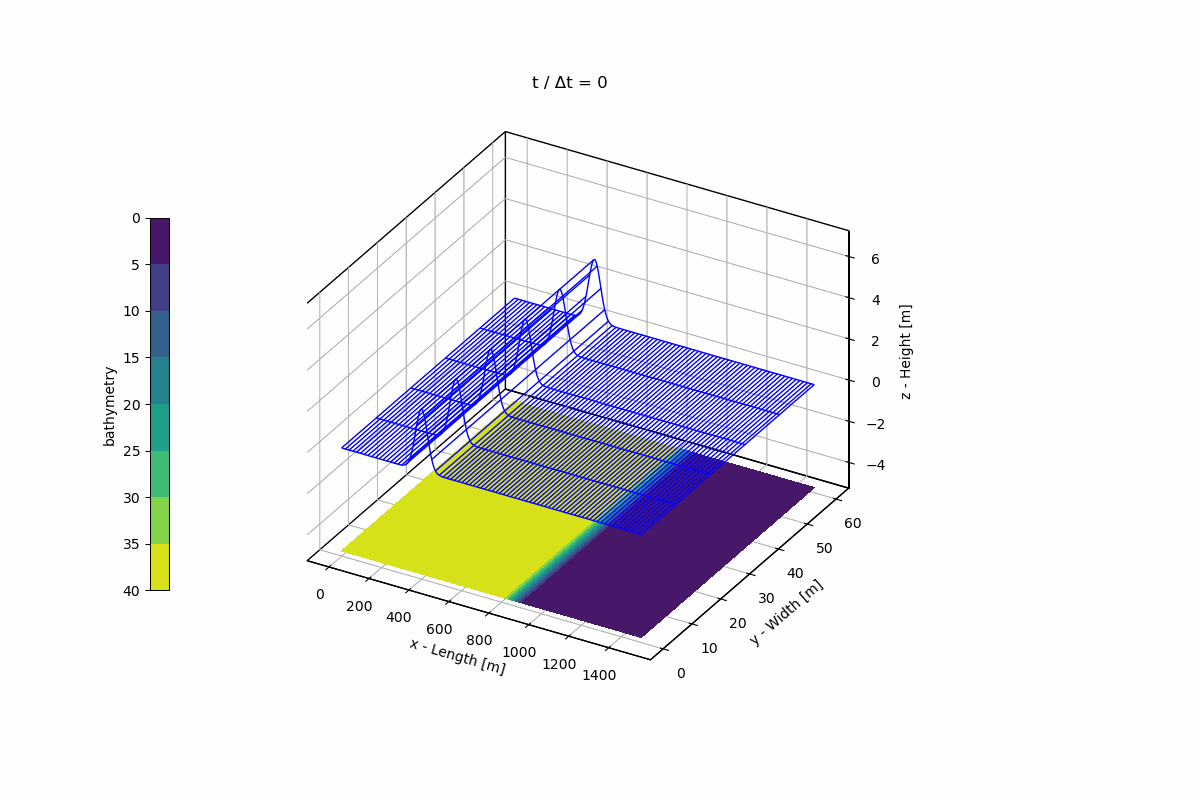

HTML(value="<a href='.\\tmpx0qmccw0.gif' target='_blank'>.\\tmpx0qmccw0.gif</a><br>")

In [11]:
show_anim(plot, range(len(output['h'])))

Maksymalna wysokość fali po uderzeniu w nadbrzeże to: 2.73 m


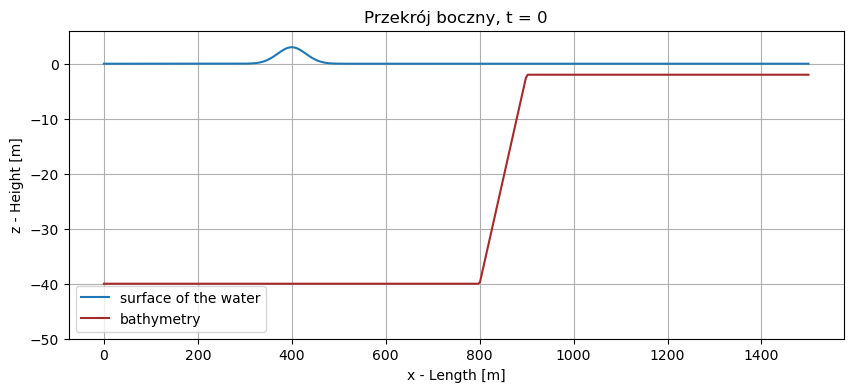

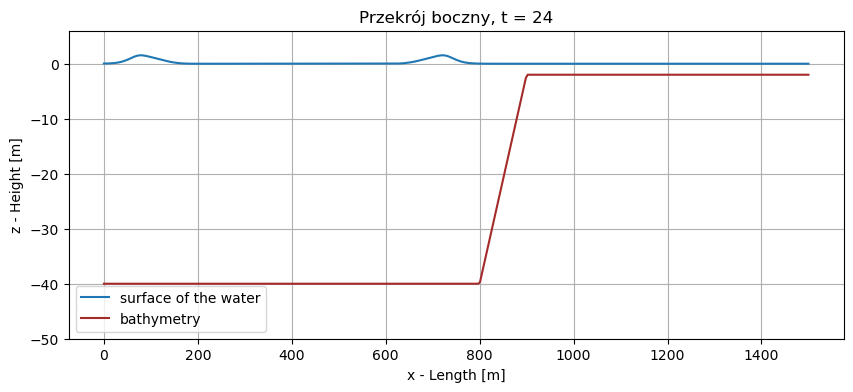

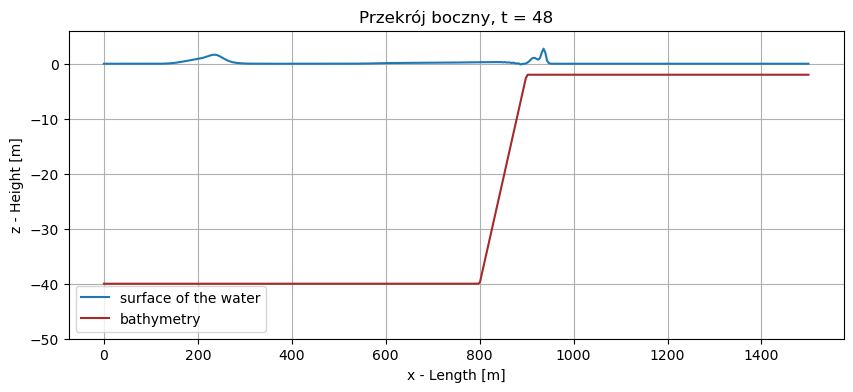

In [12]:
slice_2D_f(1)

In [13]:
bathymetry=bathymetry_f(2, deep_depth, shallow_depth, slope_start, slope_width, a, b, c, x)
tsunami=tsunami_f(amp, sigma, x0, x)

h_initial=bathymetry+tsunami

dt=0.08

output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial, bathymetry=bathymetry, 
    n_threads=1
)(
    nt=int(50/dt), g=g, dt_over_dxy=(dt/dx, dt/dy), outfreq=8   
)


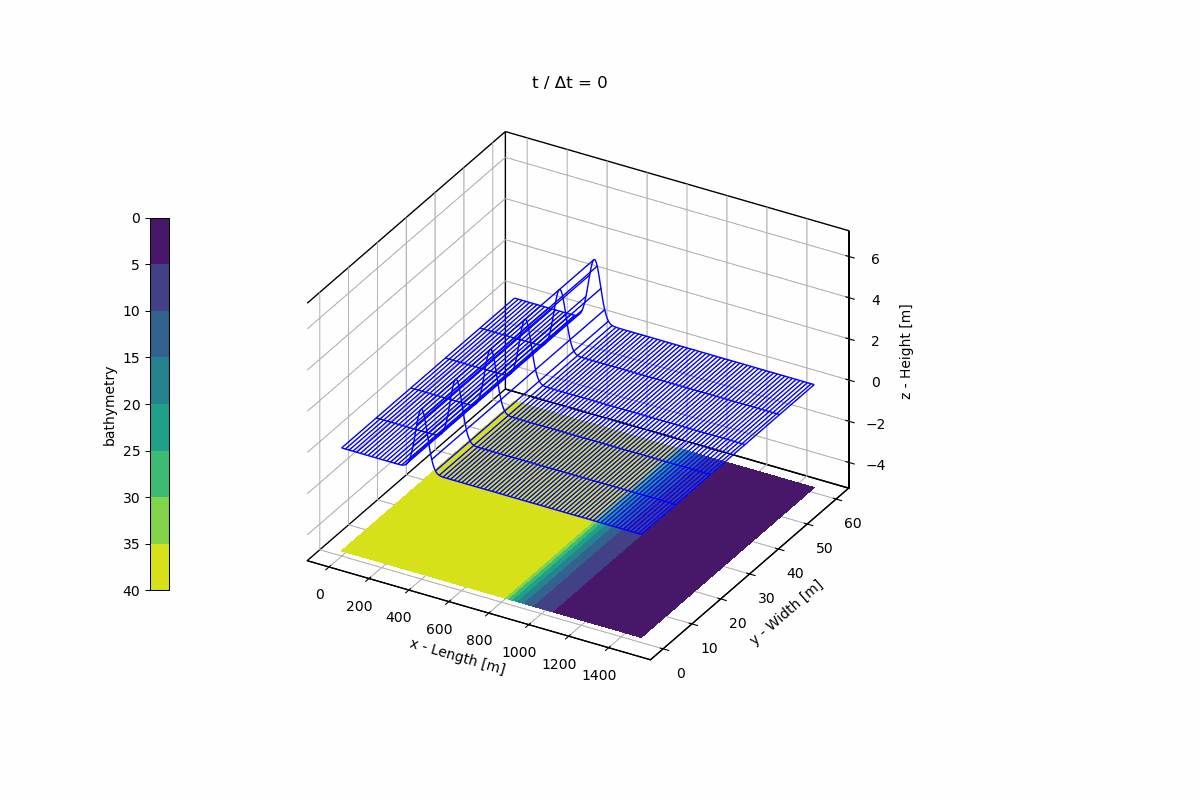

HTML(value="<a href='.\\tmppu82czpn.gif' target='_blank'>.\\tmppu82czpn.gif</a><br>")

In [14]:
show_anim(plot, range(len(output['h'])))

Maksymalna wysokość fali po uderzeniu w nadbrzeże to: 1.92 m


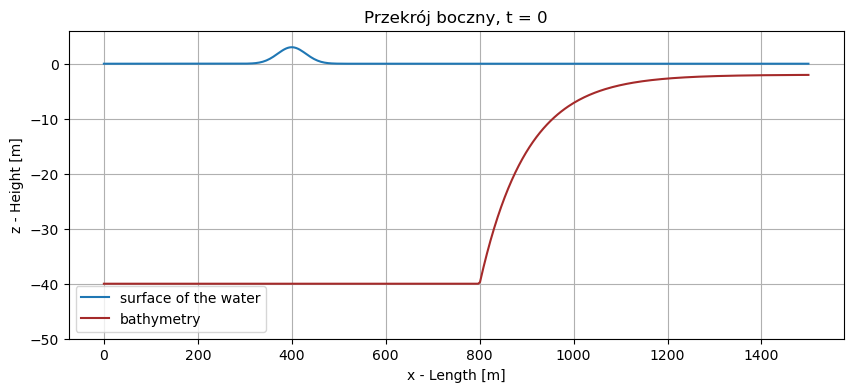

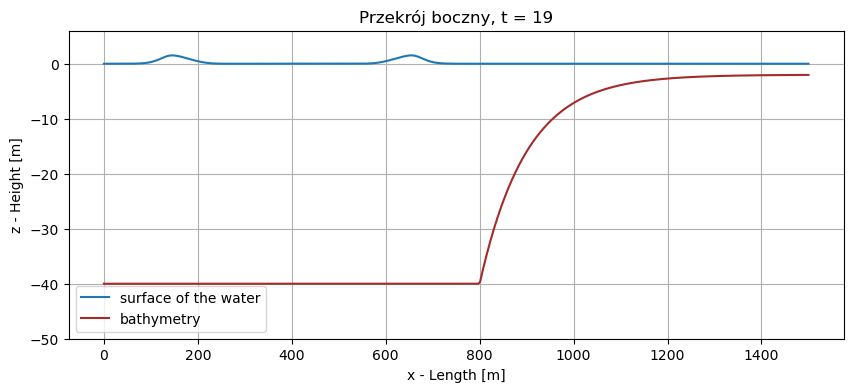

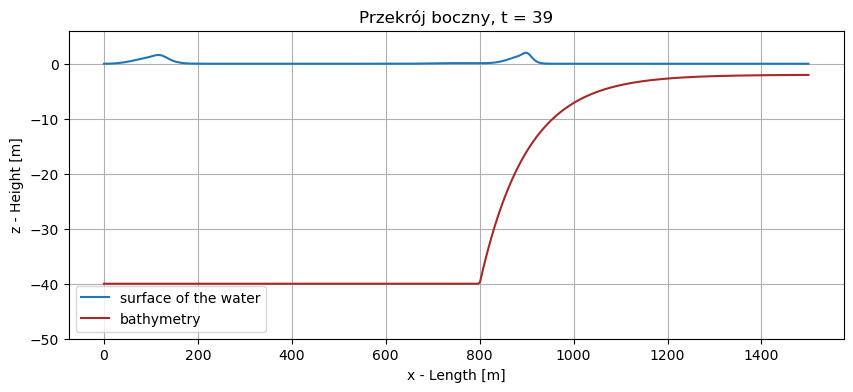

In [15]:
slice_2D_f(2)

In [16]:
bathymetry=bathymetry_f(3, deep_depth, shallow_depth, slope_start, slope_width, a, b, c, x)
tsunami=tsunami_f(amp, sigma, x0, x)

h_initial=bathymetry+tsunami

dt=0.08

output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial, bathymetry=bathymetry, 
    n_threads=1
)(
    nt=int(50/dt), g=g, dt_over_dxy=(dt/dx, dt/dy), outfreq=8   
)


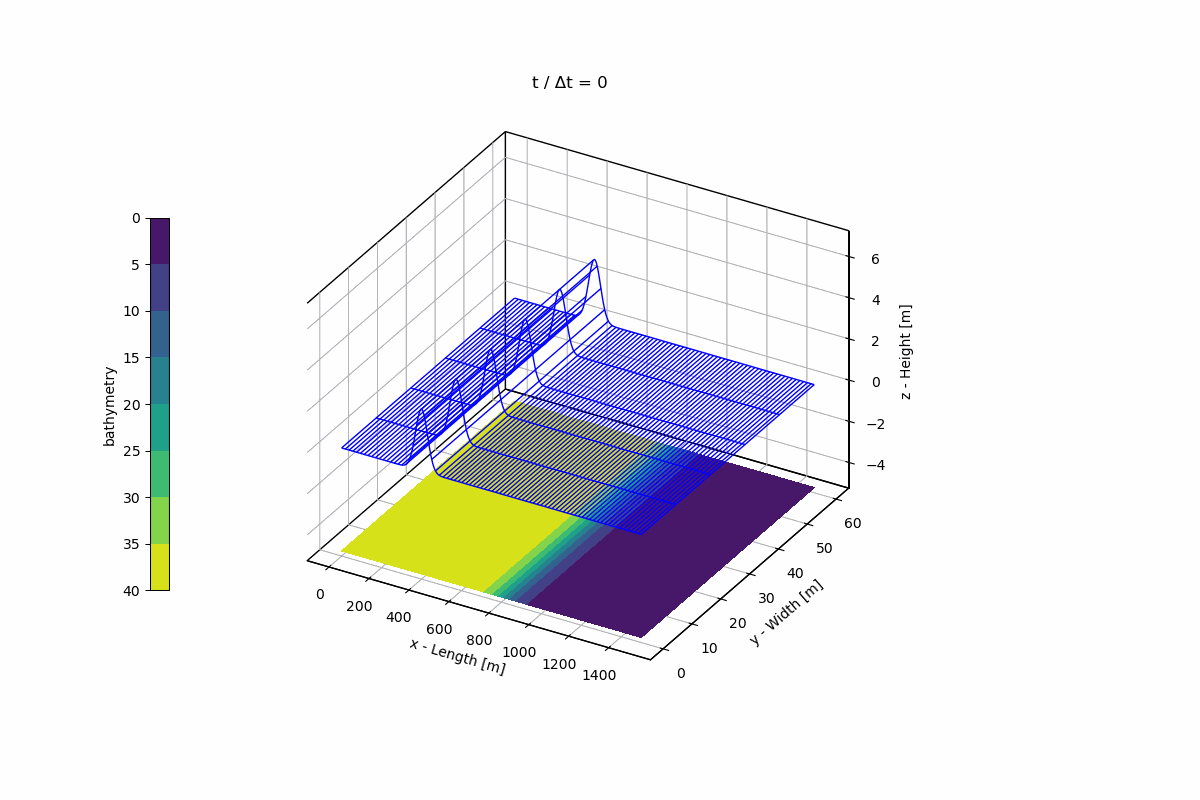

HTML(value="<a href='.\\tmp53kx_org.gif' target='_blank'>.\\tmp53kx_org.gif</a><br>")

In [17]:
show_anim(plot, range(len(output['h'])))

Maksymalna wysokość fali po uderzeniu w nadbrzeże to: 2.63 m


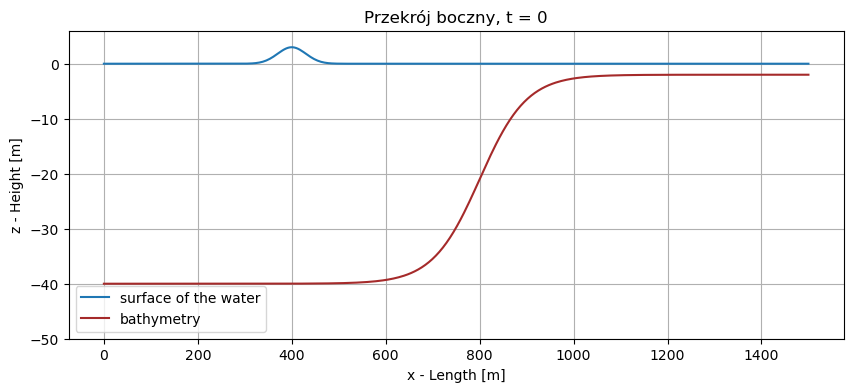

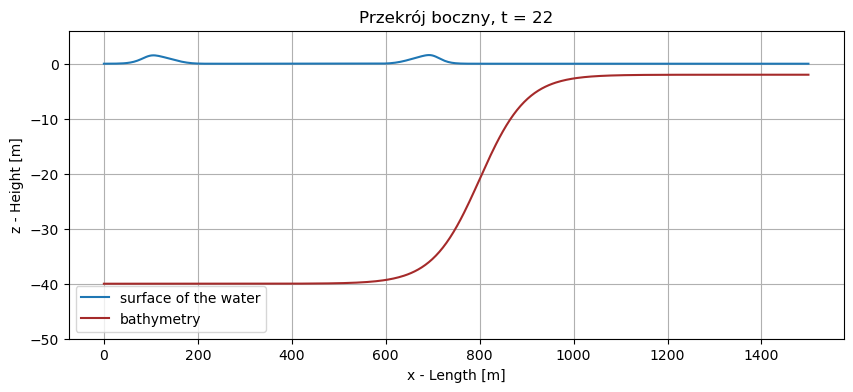

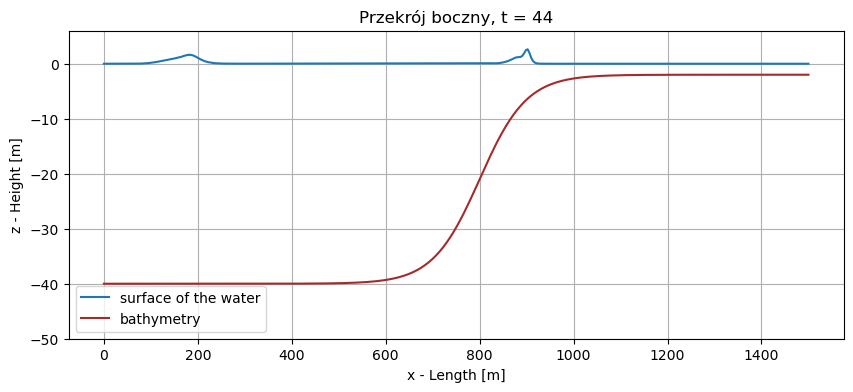

In [18]:
slice_2D_f(3)